In [72]:
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from scipy.constants import G
from matplotlib.animation import FuncAnimation

%matplotlib ipympl

In [73]:
class Vector3:
    def __init__(self, x : float = 0, y : float = 0, z : float = 0, vect : tuple = ()):
        if len(vect) == 3:
            self.x = vect[0]
            self.y = vect[1]
            self.z = vect[2]
        else:
            self.x = x
            self.y = y
            self.z = z

    def __getitem__(self, item):
        return [self.x, self.y, self.z][item]
    
    def __repr__(self):
        return f"Vector({self.x}, {self.y}, {self.z})"

    def __str__(self):
        return f"{'' if self.x >= 0 else '- '}{abs(self.x)}i {'+' if self.y >= 0 else '-'} {abs(self.y)}j {'+' if self.z >= 0 else '-'} {abs(self.z)}k"

    def __neg__(self):
        return Vector3( vect = tuple(- self[i] for i in range(3)) )

    def __add__(self, other):
        return Vector3( vect = tuple(other[i] + self[i] for i in range(3)) )
    
    def __sub__(self, other):
        return Vector3( vect = tuple(other[i] - self[i] for i in range(3)) )
    
    def __truediv__(self, divisor):
        return Vector3( vect = tuple(self[i] / divisor for i in range(3)) )
    
    def distance(self, other):
        return sqrt(sum((self[i] - other[i]) ** 2 for i in range(3)))
    
    def magnitude(self):
        return sqrt((self.x ** 2) + (self.y ** 2) + (self.z ** 2))

    def unit_vector(self):
        m = self.magnitude()
        return Vector3(self.x/m, self.y/m, self.z/m)
    
    def scale(self, scalar):
        return Vector3( vect = tuple(self[i] * scalar for i in range(3)))

    def scale_inplace(self, scalar):
        self = self.scale(scalar)
        return self
    
    def as_tuple(self):
        return (self.x, self.y, self.z)

    @staticmethod
    def zero():
        return Vector3()


No such comm: 0c80e22a2a5b48389c3853ae62fed757


In [74]:
print(Vector3(1, 13, 22) + Vector3(2, 15, -6))
print(Vector3(1, 13, 22) - Vector3(2, 15, -6))
print(Vector3(1, 1, 1).scale(50))
print(Vector3(1, 13, 22).distance(Vector3(2, 15, -6)))
print(-Vector3(-1, 2, 3))

3i + 28j + 16k
1i + 2j - 28k
50i + 50j + 50k
28.089143810376278
1i - 2j - 3k


In [75]:
#class Quat:
#    def __init__(self, )

In [76]:
class Transform:
    def __init__(self, p : Vector3, v : Vector3):
        self.position = p
        self.velocity = v

    def __str__(self):
        return f"Position: {str(self.position)} Velocity: {str(self.velocity)}"

    @staticmethod
    def empty():
        return Transform(Vector3(), Vector3())

In [77]:
class Body:
    def __init__(self, T : Transform, mass : float = 1):
        self.transform : Transform = T
        self.mass = (mass if mass > 0 else 1)

        self.useGravity = True
        self.attractOther = True
        self.isAttracted = True

    def b_direction(self, other):
        return other.transform.position - self.transform.position

    def b_distance(self,  other):
        return self.transform.position.distance(other.transform.position)

    def calc_grav(self, other, dsec):
        return (G * self.mass * other.mass) / (self.b_distance(other) ** 2) * dsec

    def apply_grav(self, other, dsec):
        fgrav = self.calc_grav(other, dsec)
        
        fdir = self.transform.position - other.transform.position

        f = fdir.scale(fgrav)

        if self.useGravity:
            self.transform.velocity += (f / self.mass)
        
        if other.useGravity:
            other.transform.velocity += -(f / other.mass)

        return f

    def apply_velocity(self):
        self.transform.position += self.transform.velocity

    def print_vel(self):
        print(f"Velocity: {self.transform.velocity}")

    def print_pos(self):
        print(f"Position: {self.transform.position}")

    @staticmethod
    def empty():
        return Body(Transform.empty())


In [78]:
b1 = Body(Transform.empty())
b2 = Body(Transform(Vector3(1, 3, 1), Vector3(0, 0, 0)))

print(b1.apply_grav(b2, 1).magnitude())

2.0123771671153672e-11


In [79]:
class Sim:
    def __init__(self, anim_seconds = 2*np.pi, num_frames = 128):
        self.bodies = []

        self.anim_seconds = anim_seconds
        self.num_frames = num_frames

        self.frames = []

        self.max_pos = [0, 0, 0]

        self.gen_cmap()
        

    def run(self):
        for frame in np.linspace(0, self.anim_seconds, self.num_frames):
            self.calc_body_grav_effects()

            self.step()

            frame_info = []

            for body in self.bodies:
                for val in range(3):
                    if abs(body.transform.position[val]) > self.max_pos[val]:
                        self.max_pos[val] = abs(body.transform.position[val])
                frame_info.append(body.transform.position)
        
            self.frames.append(frame_info)

    def gen_cmap(self):
        self.cmap = plt.cm.get_cmap('hsv', len(self.bodies))
        return self.cmap

    def add_body(self, body : Body):
        self.bodies.append(body)
        self.gen_cmap()
    
    def add_body(self, T : Transform, mass : float = 1):
        self.bodies.append(Body(T, mass))
    
    def calc_body_grav_effects(self, dsec : float = 1):
        for index in range(len(self.bodies)):
            for body in self.bodies[index + 1:]:
                self.bodies[index].apply_grav(body, 1)
    
    def print_bodies(self):
        for body in range(len(self.bodies)):
            print(f"Body {body}")
            self.bodies[body].print_pos()
            self.bodies[body].print_vel()
            print()

    def step(self):
        for body in self.bodies:
            body.apply_velocity()

In [80]:
sim = Sim(num_frames=64)
#sim = Sim(num_frames = 1)

sim.add_body(Transform.empty())
sim.add_body(Transform(Vector3(1, 3, 1), Vector3(0, 0, 0)))

sim.calc_body_grav_effects(0)

sim.run()

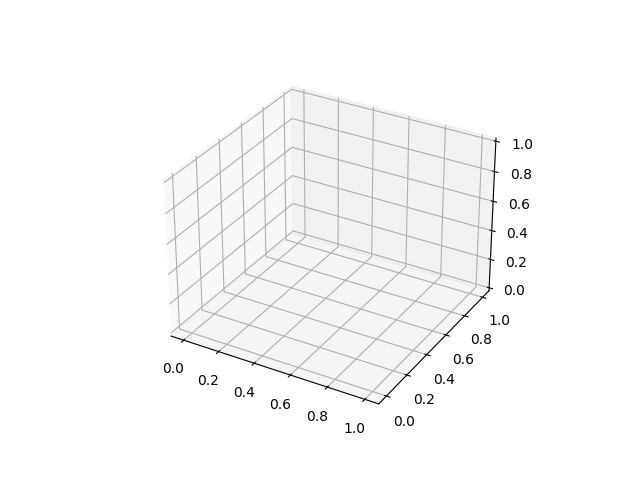

In [81]:
frame_count = 0

fig = plt.figure()
ax = plt.axes(projection = '3d')

ax.scatter([], [], [])

sim = Sim(2*np.pi*4, 128*4)

#sim.add_body(Transform(Vector3(20, 20, 20), Vector3(2, -2, 3)), 10000)
#sim.add_body(Transform(Vector3(-20, -20, -20), Vector3(2, -2, 3)), 10000)
#sim.add_body(Transform(Vector3(0, 0, 0), Vector3(0, 0, 0)), 100000000000)

sim.add_body(Transform(Vector3(30, 15, 25), Vector3(0, -1, 0)), 100000000000)
sim.add_body(Transform(Vector3(-20, -20, -20), Vector3(1, 1, 1)), 100000000000)
#sim.add_body(Transform(Vector3(0, 0, 0), Vector3(0, 1, 0)), 100000000000)
#sim.add_body(Transform(Vector3(40, 40, 40), Vector3(-3, 3, -3)), 1)
sim.add_body(Transform(Vector3(-40, -55, 60), Vector3(4, 4, 4)), 100000000000)
sim.add_body(Transform(Vector3(100, 100, 100), Vector3(-1, -1, -1)), 100000000000)

sim.calc_body_grav_effects(0)

sim.run()

def init():
    ax.clear()
    
    ax.axes.set_xlim3d(left=-sim.max_pos[0], right=sim.max_pos[0]) 
    ax.axes.set_ylim3d(bottom=-sim.max_pos[1], top=sim.max_pos[1]) 
    ax.axes.set_zlim3d(bottom=-sim.max_pos[2], top=sim.max_pos[2]) 

    global frame_count
    frame_count = 0
    

def upd(frame):
    ax.clear()
    
    ax.axes.set_xlim3d(left=-sim.max_pos[0], right=sim.max_pos[0]) 
    ax.axes.set_ylim3d(bottom=-sim.max_pos[1], top=sim.max_pos[1]) 
    ax.axes.set_zlim3d(bottom=-sim.max_pos[2], top=sim.max_pos[2]) 
    
    global frame_count
    frame_count += 1

    ax.scatter([sim.frames[frame_count][a][0] for a in range(len(sim.frames[frame_count]))], [sim.frames[frame_count][a][1] for a in range(len(sim.frames[frame_count]))], [sim.frames[frame_count][a][2] for a in range(len(sim.frames[frame_count]))], c = ['Blue', 'Green', 'Red', 'Purple'], s = 10)
    
anim = FuncAnimation(fig, upd, frames=np.linspace(0, sim.anim_seconds, sim.num_frames),
                    init_func=init, blit=True)

If run locally with the correct libraries installed, this is the animation produced:

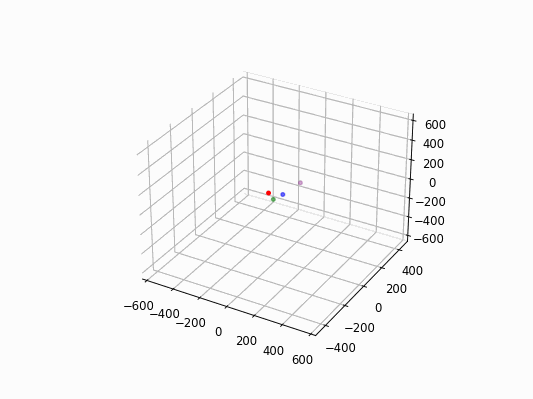

In [82]:
anim.frame_seq = anim.new_frame_seq() 
anim.event_source.start()

In [83]:
#from matplotlib.animation import PillowWriter

#writer = PillowWriter(fps=15,
#                                 metadata=dict(artist='Josh Hagstrom'),
#                                 bitrate=1800)
#anim.save('scatter.gif', writer=writer)